In [587]:
import pymc3 as pm
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as ss
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay, confusion_matrix
from statsmodels.formula.api import ols, logit, glm

import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

In [280]:
def model_factory(X, y=None):
    """Generates a possion regression model"""
    if y is None:
        y = pd.Series(np.zeros(X.shape[0]))

    with pm.Model() as model:
        betas = []
        lm_mu = 0
        for col_nm, feature in X.iteritems():
            beta = pm.Normal(col_nm, 0, 100)
            betas.append(beta)
            lm_mu += beta * feature
        
        lam = pm.math.exp(lm_mu)
        y_hat = pm.Poisson(y.name if y.name else 'y_hat', mu=lam, observed=y)
    return model

# Badhealth dataset

In [3]:
bh_data = sm.datasets.get_rdataset('badhealth', 'COUNT').data

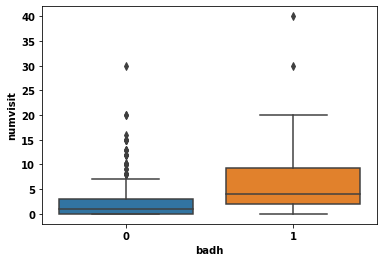

<AxesSubplot:xlabel='badh', ylabel='age'>

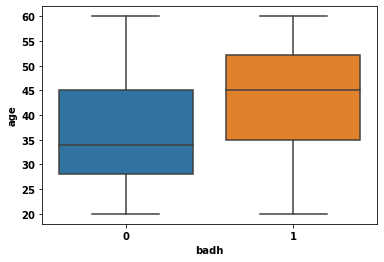

In [33]:
sns.boxplot(data=bh_data, x='badh', y='numvisit')
plt.show()

sns.boxplot(data=bh_data, x='badh', y='age')
plt.show()

In [ ]:
def model_factory(X, y=None):
    """Generates a possion regression model"""
    if y is None:
        y = pd.Series(np.zeros(X.shape[0]))

    with pm.Model() as model:
        betas = []
        lm_mu = 0
        for col_nm, feature in X.iteritems():
            beta = pm.Normal(col_nm, 0, 1e4)
            betas.append(beta)
            lm_mu += beta * feature
        
        lam = pm.math.exp(lm_mu)
        y_hat = pm.Poisson(y.name if y.name else 'y_hat', mu=lam, observed=y)
    return model

In [230]:
X = bh_data[['badh', 'age']]
# X['badh_age'] = X.badh * X.age
X = sm.add_constant(X)
y = bh_data['numvisit']

with model_factory(X, y) as model:
    step = pm.HamiltonianMC()
    res = pm.sample(10000, tune=1500, step=step, chains=3, return_inferencedata=True)

Multiprocess sampling (3 chains in 4 jobs)
HamiltonianMC: [age, badh, const]


Sampling 3 chains for 1_500 tune and 10_000 draw iterations (4_500 + 30_000 draws total) took 32 seconds.
The acceptance probability does not match the target. It is 0.7856401480652212, but should be close to 0.65. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7527532418850453, but should be close to 0.65. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7590241766321565, but should be close to 0.65. Try to increase the number of tuning steps.


In [231]:
az.summary(res)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
const,0.446,0.072,0.314,0.583,0.001,0.0,11940.0,15608.0,1.0
badh,1.108,0.046,1.021,1.193,0.000,0.0,23082.0,18942.0,1.0
age,0.006,0.002,0.002,0.009,0.000,0.0,11275.0,14962.0,1.0


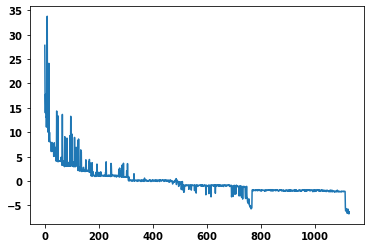

In [236]:
lam_pred = (res.posterior.median().to_pandas() * X).sum(1)
ypred = np.exp(lam_pred)
resid = y - ypred

plt.plot(resid)

<AxesSubplot:>

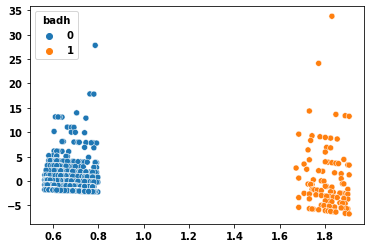

In [235]:
sns.scatterplot(x=lam_pred, y=resid, hue=X.badh)

In [239]:
# simple, no interactions
pm.loo(res, scale='deviance')

Computed from 30000 by 1127 log-likelihood matrix

             Estimate       SE
deviance_loo  5651.06   219.78
p_loo           15.35        -

In [229]:
# 1st order interactions
pm.loo(res, scale='deviance')

Computed from 30000 by 1127 log-likelihood matrix

             Estimate       SE
deviance_loo  5650.73   218.17
p_loo           20.43        -

In [224]:
# 1st & 2nd order interactions
pm.loo(res, scale='deviance')

Computed from 30000 by 1127 log-likelihood matrix

             Estimate       SE
deviance_loo  5656.98   217.40
p_loo           30.93        -

In [188]:
X_test = pd.DataFrame(
    [[1, 0, 35,  0],
     [1, 1, 35, 35]],
    columns = ['const', 'badh', 'age', 'badh_age']
)

with model_factory(X_test, None) as test_model:
    ppc = pm.sample_posterior_predictive(res)

Median:
 [[2.]
 [6.]]
Person 2 > Person 1: 0.9178333333333333


<AxesSubplot:ylabel='Probability'>

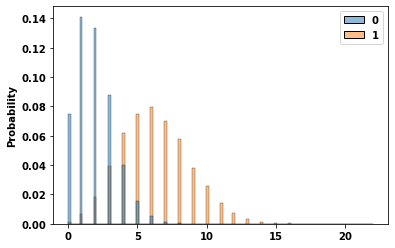

In [217]:
print('Median:\n', np.median(ppc['numvisit'], axis=0).reshape(-1,1))
print('Person 2 > Person 1:', np.mean(ppc['numvisit'][:,1] > ppc['numvisit'][:,0]))
sns.histplot(data=ppc['numvisit'], stat='probability')

# Caller Dataset

In [1115]:
caller_data = pd.read_csv('caller.csv')

<AxesSubplot:xlabel='isgroup2'>

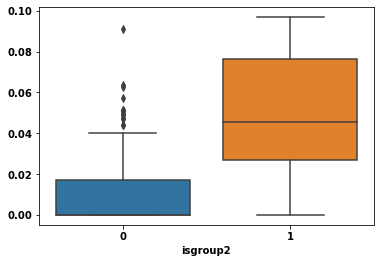

In [1116]:
sns.boxplot(data=caller_data, x='isgroup2', y=caller_data.calls/caller_data.days_active)

In [1185]:
def model_factory(X, y=None, weights=None):
    """Generates a possion regression model"""
    if y is None:
        y = pd.Series(np.zeros(X.shape[0]))

    coords = {'obs_idx': X.index, 'feature_idx': X.columns}
    with pm.Model(coords=coords) as model:
        _X = pm.Data('X', X, dims=('obs_idx', 'feature_idx'))
        _y = pm.Data('y', y, dims='obs_idx')

        beta = pm.Normal('beta', mu=0, sigma=10, dims='feature_idx')
        lm_mu = pm.math.dot(_X, beta)
        lam = pm.math.exp(lm_mu)  # rate per day
        if weights is not None:
            lam *= weights  # might be multiple days
        y_hat = pm.Poisson(y.name if y.name else 'y_hat', mu=lam, observed=_y)
    return model

In [1186]:
X = caller_data[['age', 'isgroup2']]
X = sm.add_constant(X)
weights = caller_data.days_active
y = caller_data.calls

with model_factory(X, y, weights=weights) as model:
    # res = pm.find_MAP()
    step = pm.HamiltonianMC()
    res = pm.sample(10000, tune=1500, step=step, chains=3, return_inferencedata=True)

Multiprocess sampling (3 chains in 4 jobs)
HamiltonianMC: [beta]


Sampling 3 chains for 1_500 tune and 10_000 draw iterations (4_500 + 30_000 draws total) took 27 seconds.
There were 171 divergences after tuning. Increase `target_accept` or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7576787791640458, but should be close to 0.65. Try to increase the number of tuning steps.


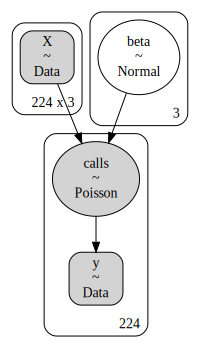

In [1198]:
pm.model_to_graphviz(model)

In [1187]:
az.summary(res)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[const],-2.562,0.433,-3.367,-1.748,0.004,0.003,12994.0,15045.0,1.0
beta[age],-0.065,0.015,-0.093,-0.038,0.000,0.000,12892.0,15109.0,1.0
beta[isgroup2],1.548,0.155,1.259,1.841,0.001,0.001,35625.0,14614.0,1.0


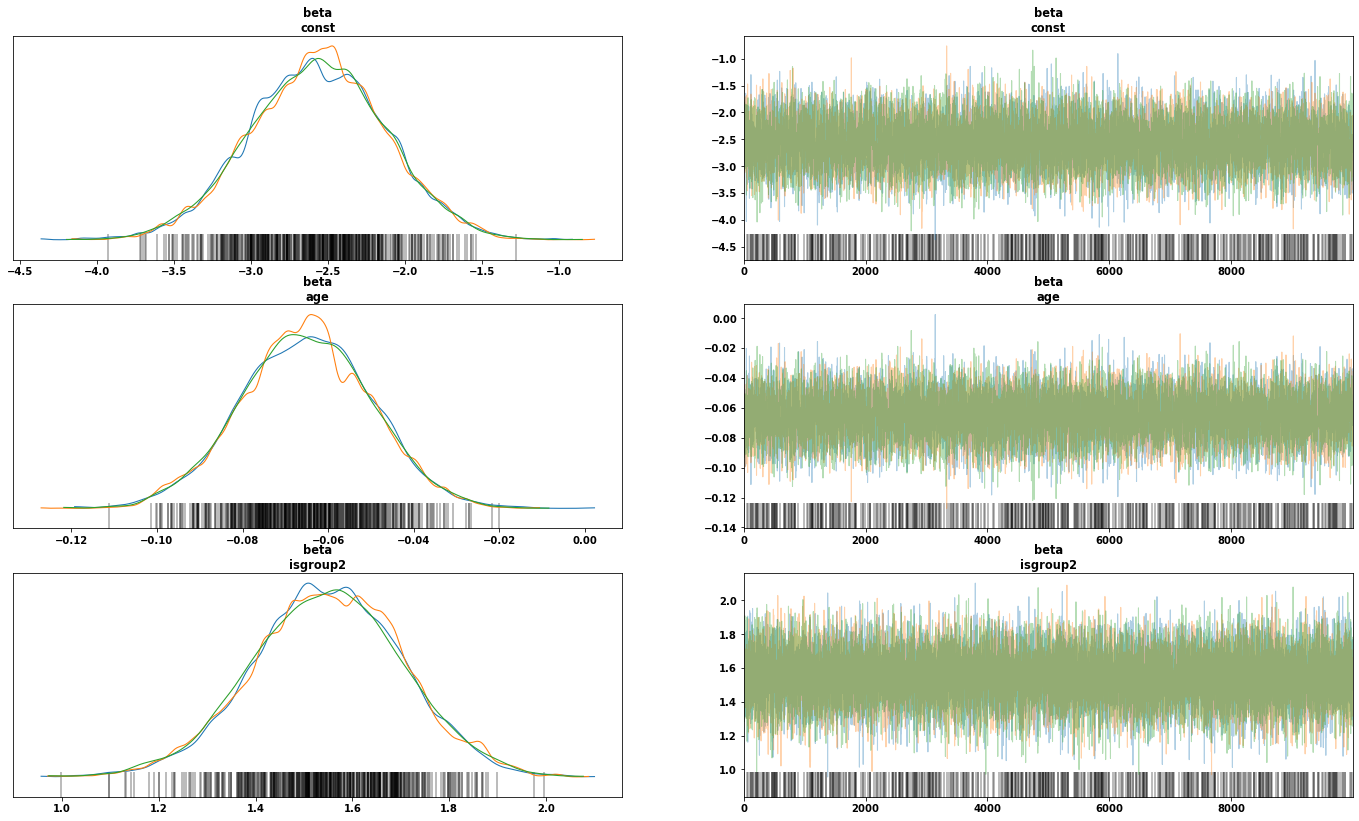

In [1156]:
_ = az.plot_trace(res, compact=False, figsize=(24,14))

In [1188]:
X_test = pd.DataFrame([[1.0, 29, 1]], columns=X.columns)
n_test = pd.Series([30], index=X_test.index)
y_test = pd.Series(np.zeros(X_test.shape[0], dtype=np.int64), index=X_test.index)

with model_factory(X_test, y_test, weights=n_test) as model_test:
    ppc = pm.sample_posterior_predictive(res)

In [1196]:
np.mean(ppc['y_hat'].ravel() >= 3)

0.2337

<AxesSubplot:ylabel='Count'>

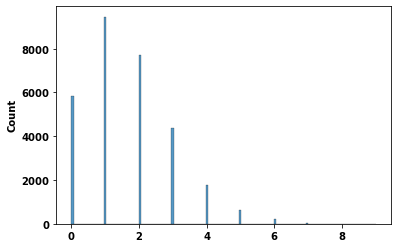

In [1197]:
sns.histplot(ppc['y_hat'].ravel())

# Cookies Dataset

In [354]:
cookies_data = pd.read_csv('cookies.DAT', sep=' ')

<AxesSubplot:xlabel='location', ylabel='chips'>

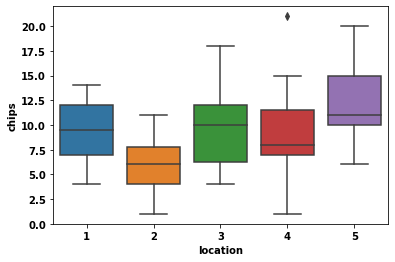

In [360]:
sns.boxplot(data=cookies_data, x='location', y='chips')

In [488]:
loc_idx, locs = pd.factorize(cookies_data.location)
X = cookies_data[['location']]
y = cookies_data['chips']
coords = {'locs': locs, 'obs_idx': X.index.values}

with pm.Model(coords=coords) as model:
    _loc_idx = pm.Data('loc_idx', loc_idx, dims='obs_idx')

    mu = pm.Gamma('lam_mu', alpha=2, beta=1/5)
    sig = pm.Exponential('lam_sig', lam=1)
    alpha = pm.Deterministic('alpha', mu**2 / sig**2)
    beta = pm.Deterministic('beta', mu / sig**2)

    lam = pm.Gamma('lam', alpha, beta, dims='locs')
    y_hat = pm.Poisson('chips', mu=lam[_loc_idx], observed=y, dims='obs_idx')

    # print(pm.find_MAP())
    res = pm.sample(10000, tune=1500, chains=3, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [lam, lam_sig, lam_mu]


Sampling 3 chains for 1_500 tune and 10_000 draw iterations (4_500 + 30_000 draws total) took 21 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [490]:
az.summary(res)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lam_mu,9.108,0.969,7.252,10.928,0.007,0.005,21838.0,16929.0,1.0
lam_sig,2.062,0.700,0.941,3.327,0.005,0.004,19022.0,16433.0,1.0
alpha,25.892,16.737,3.541,55.918,0.128,0.102,19534.0,16104.0,1.0
beta,2.851,1.837,0.397,6.153,0.014,0.011,19256.0,16477.0,1.0
lam[1],9.284,0.535,8.272,10.274,0.003,0.002,27340.0,22088.0,1.0
lam[2],6.238,0.460,5.365,7.097,0.003,0.002,26224.0,18242.0,1.0
lam[3],9.526,0.536,8.553,10.559,0.003,0.002,25409.0,20460.0,1.0
lam[4],8.945,0.529,7.969,9.938,0.003,0.002,25762.0,20934.0,1.0
lam[5],11.745,0.618,10.594,12.907,0.004,0.003,22378.0,18893.0,1.0


In [491]:
az.loo(res, scale='deviance')

Computed from 30000 by 150 log-likelihood matrix

             Estimate       SE
deviance_loo   789.58    21.36
p_loo            5.72        -

In [540]:
post_res = pm.sample_posterior_predictive(res, model=model, var_names=['lam_mu', 'lam_sig'])

In [541]:
post_alpha = post_res['lam_mu'] ** 2 / post_res['lam_sig'] ** 2
post_beta = post_res['lam_mu'] / post_res['lam_sig'] ** 2
post_lam = ss.gamma(a=post_alpha, scale=1/post_beta).rvs()

<AxesSubplot:ylabel='Count'>

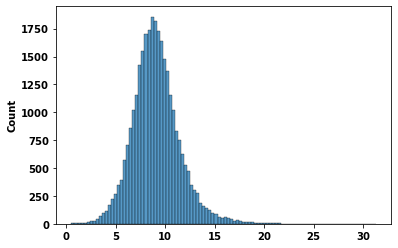

In [543]:
sns.histplot(post_lam, bins=100)

# pctgrowth Dataset

In [546]:
pctg_data = pd.read_csv('pctgrowth.csv')

In [568]:
print(pctg_data.groupby('grp').y.mean())
print(pctg_data.groupby('grp').y.var())

grp
1    0.990000
2   -1.616667
3   -1.162500
4    0.253333
5   -0.371429
Name: y, dtype: float64
grp
1    0.705444
2    4.053667
3    1.236964
4    0.331238
5    0.471429
Name: y, dtype: float64


In [559]:
X = pctg_data[['grp']]
y = pctg_data['y']
grp_idx, grps = pd.factorize(pctg_data.grp)
coords = {'grps': grps, 'obs_idx': X.index.values}

with pm.Model(coords=coords) as model:
    tau = pm.InverseGamma('mu_var', alpha=1/2, beta=3/2)
    mu = pm.Normal('mu_mean', mu=0, sigma=1e6)
    y_mu = pm.Normal('y_mu', mu=mu, sigma=pm.math.sqrt(tau), dims='grps')

    var = pm.InverseGamma('y_var', alpha=1, beta=1)
    y_hat = pm.Normal('y_hat', mu=y_mu[grp_idx], sigma=pm.math.sqrt(var), observed=y, dims='obs_idx')

    # print(pm.find_MAP())
    res = pm.sample(10000, tune=1500, chains=3, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [y_var, y_mu, mu_mean, mu_var]


Sampling 3 chains for 1_500 tune and 10_000 draw iterations (4_500 + 30_000 draws total) took 21 seconds.


In [570]:
az.summary(res)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_mean,-0.368,0.688,-1.653,0.942,0.005,0.005,21849.0,15819.0,1.0
y_mu[1],0.902,0.310,0.313,1.473,0.002,0.001,25908.0,18741.0,1.0
y_mu[2],-1.484,0.400,-2.231,-0.719,0.003,0.002,24859.0,19126.0,1.0
y_mu[3],-1.096,0.345,-1.743,-0.450,0.002,0.001,28433.0,19965.0,1.0
y_mu[4],0.223,0.252,-0.269,0.681,0.002,0.001,26953.0,20219.0,1.0
y_mu[5],-0.372,0.263,-0.865,0.125,0.002,0.001,27395.0,19137.0,1.0
mu_var,2.319,2.797,0.299,5.694,0.025,0.018,17109.0,15233.0,1.0
y_var,1.000,0.208,0.636,1.374,0.001,0.001,24467.0,20474.0,1.0


# Leinhard Revisit

In [608]:
leinh = sm.datasets.get_rdataset('Leinhardt', 'carData').data
leinh = leinh[~leinh.isna().any(1)]

In [606]:
leinh.sample(10)

,income,infant,region,oil
Sri.Lanka,162,45.1,Asia,no
Egypt,210,114.0,Africa,no
Mali,50,120.0,Africa,no
Venezuela,1240,51.7,Americas,yes
Niger,70,200.0,Africa,no
Chile,590,78.0,Americas,no
El.Salvador,319,58.2,Americas,no
Cambodia,123,100.0,Asia,no
Peru,335,65.1,Americas,no
Lebanon,631,13.6,Asia,no


In [809]:
X = leinh[['income','oil']]
X.loc[:,'oil'] = X.oil.apply(lambda x: 1 if x=='yes' else 0)
X.loc[:,'income'] = np.log(X.income)
y = np.log(leinh['infant'])

region_idx, regions = pd.factorize(leinh['region'])
coords = {'regions': regions, 'col_idx': X.columns, 'obs_idx': X.index}
with pm.Model(coords=coords) as model:
    _X = pm.Data('X', X, dims=('obs_idx', 'col_idx'))

    int_mu = pm.Normal('int_mu', mu=0, sigma=1e6)
    int_var = pm.InverseGamma('int_var', alpha=1/2, beta=1*10/2)
    int_sig = pm.Deterministic('int_sig', pm.math.sqrt(int_var))
    intercept = pm.Normal('region', mu=int_mu, sigma=int_sig, dims='regions')

    beta = pm.Normal('beta', mu=0, sigma=1e6, dims='col_idx')
    mu = intercept[region_idx] + pm.math.dot(_X, beta)
    var = pm.InverseGamma('var', alpha=5/2, beta=5*10/2)
    sigma = pm.Deterministic('sigma', pm.math.sqrt(var))
    y_hat = pm.Normal('infant', mu=mu, sigma=sigma, observed=y, dims='obs_idx')

    # print(pm.find_MAP())
    res = pm.sample(10000, tune=2500, chains=3, return_inferencedata=True)

C:\Users\ztang\miniconda3\envs\pm3env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [var, beta, region, int_var, int_mu]


Sampling 3 chains for 2_500 tune and 10_000 draw iterations (7_500 + 30_000 draws total) took 46 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [810]:
az.summary(res, var_names=['region', 'beta', 'int_mu', 'int_sig', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
region[Asia],5.869,0.617,4.721,7.044,0.008,0.005,6560.0,10083.0,1.0
region[Europe],5.568,0.850,4.042,7.243,0.011,0.008,6396.0,9836.0,1.0
region[Americas],6.036,0.694,4.732,7.341,0.009,0.006,6488.0,9844.0,1.0
region[Africa],6.573,0.552,5.558,7.634,0.007,0.005,6542.0,9948.0,1.0
beta[income],-0.345,0.105,-0.546,-0.154,0.001,0.001,6202.0,8983.0,1.0
beta[oil],0.645,0.354,-0.025,1.297,0.003,0.002,16959.0,17912.0,1.0
int_mu,6.021,1.302,3.568,8.426,0.014,0.010,9076.0,11809.0,1.0
int_sig,2.038,1.030,0.823,3.743,0.011,0.008,12311.0,11048.0,1.0
sigma,0.919,0.066,0.794,1.040,0.001,0.000,14992.0,9276.0,1.0


In [811]:
az.loo(res, scale='deviance')

Computed from 30000 by 101 log-likelihood matrix

             Estimate       SE
deviance_loo   218.91    10.85
p_loo            4.40        -

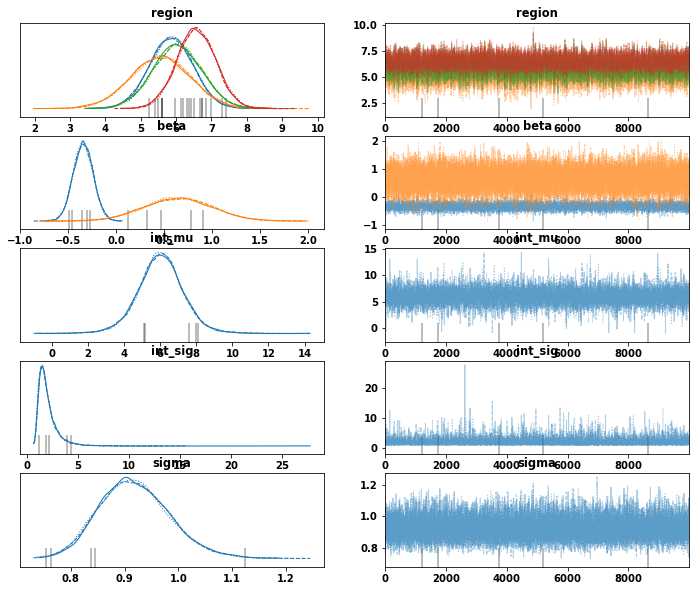

In [812]:
_ = az.plot_trace(res, var_names=['region', 'beta', 'int_mu', 'int_sig', 'sigma'])

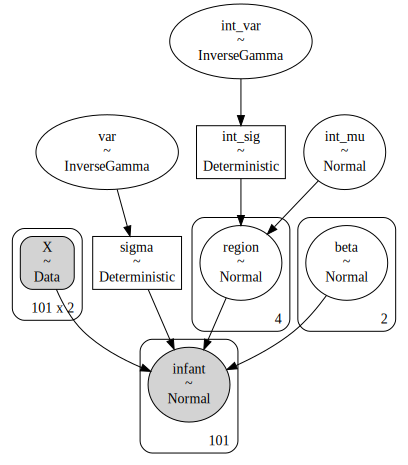

In [813]:
pm.model_to_graphviz(model)

In [814]:
with model:
    ppc = pm.sample_posterior_predictive(res)

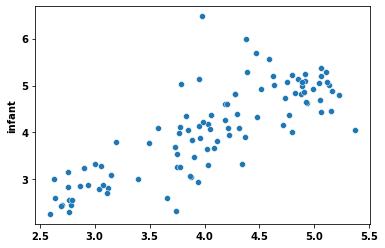

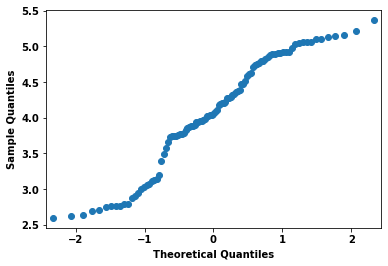

In [815]:
ypred = pd.Series(np.median(ppc['infant'], axis=0), index=y.index)
resid = y - ypred

sns.scatterplot(y=y, x=ypred)
plt.show()

_ = sm.qqplot(ypred)
plt.show()

# OME Revisit

In [791]:
ome_data = sm.datasets.get_rdataset('OME', 'MASS').data
ome_data = ome_data[~ome_data.isna().any(1)]
ome_data.loc[:, 'cor_pct'] = ome_data['Correct'] / ome_data['Trials']
ome_data = pd.get_dummies(ome_data, columns=['OME', 'Noise'])

C:\Users\ztang\miniconda3\envs\pm3env\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [792]:
ome_data.sample(5)

,ID,Age,Loud,Correct,Trials,cor_pct,OME_high,OME_low,Noise_coherent,Noise_incoherent
640,63,30,45,0,1,0.000,0,1,1,0
421,48,30,45,6,6,1.000,1,0,0,1
183,21,60,45,3,8,0.375,0,1,1,0
72,8,30,40,3,4,0.750,0,1,1,0
745,67,30,45,2,2,1.000,0,1,0,1


In [780]:
# there are multiple 8-20 oberservatins per children
ome_data.groupby('ID')['Age'].count().describe()

count    63.000000
mean     11.301587
std       3.513269
min       8.000000
25%      10.000000
50%      10.000000
75%      10.000000
max      20.000000
Name: Age, dtype: float64

In [879]:
X = ome_data[['Age', 'Loud', 'OME_low', 'Noise_incoherent']]
child_idx, children = pd.factorize(ome_data.ID)
n_trials = ome_data['Trials']
y_success = ome_data['Correct']

coords = {'obs_idx': X.index, 'feature_idx': X.columns, 'children': children}
with pm.Model(coords=coords) as model:
    _X = pm.Data('X', X, dims=('obs_idx', 'feature_idx'))
    _N = pm.Data('N', n_trials, dims='obs_idx')

    int_mu = pm.Normal('int_mu', mu=0, sigma=10)
    int_var = pm.InverseGamma('int_var', alpha=1/2, beta=1/2)
    int_sig = pm.Deterministic('int_sig', pm.math.sqrt(int_var))
    intercept = pm.Normal('child', mu=int_mu, sigma=int_sig, dims='children')

    beta = pm.Normal('beta', mu=0, sigma=4, dims='feature_idx')
    lm_mu = intercept[child_idx] + pm.math.dot(_X, beta)
    p = pm.Deterministic('p', pm.invlogit(lm_mu), dims='obs_idx')
    y_hat = pm.Binomial('correct', n=_N, p=p, observed=y_success, dims='obs_idx')

    res = pm.sample(10000, tune=10000, chains=3, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [beta, child, int_var, int_mu]


Sampling 3 chains for 10_000 tune and 10_000 draw iterations (30_000 + 30_000 draws total) took 119 seconds.
The acceptance probability does not match the target. It is 0.8844919603426189, but should be close to 0.8. Try to increase the number of tuning steps.
There were 206 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


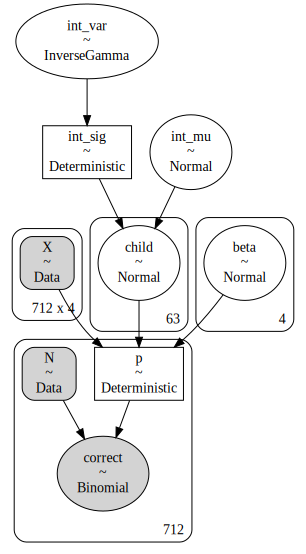

In [835]:
pm.model_to_graphviz(model)

In [880]:
pm.summary(res, var_names=['beta', 'child', 'int_mu', 'int_sig'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[Age],0.021,0.005,0.012,0.030,0.000,0.000,952.0,2947.0,1.00
beta[Loud],0.174,0.009,0.157,0.191,0.001,0.000,324.0,631.0,1.01
beta[OME_low],-0.203,0.166,-0.515,0.105,0.003,0.002,2636.0,8439.0,1.00
beta[Noise_incoherent],1.604,0.115,1.384,1.817,0.002,0.002,2859.0,10166.0,1.00
child[1],-7.577,0.534,-8.577,-6.545,0.031,0.022,301.0,586.0,1.01
...,...,...,...,...,...,...,...,...,...
child[88],-7.695,0.530,-8.719,-6.710,0.029,0.021,323.0,649.0,1.01
child[91],-7.486,0.540,-8.470,-6.442,0.029,0.021,339.0,716.0,1.01
child[95],-7.664,0.540,-8.631,-6.590,0.030,0.022,313.0,628.0,1.01
int_mu,-7.514,0.470,-8.367,-6.577,0.030,0.021,242.0,405.0,1.01


In [882]:
pm.loo(res, scale='deviance')

Computed from 30000 by 712 log-likelihood matrix

             Estimate       SE
deviance_loo  1276.40    47.49
p_loo           33.50        -

# Mixture Models

In [920]:
mix_data = pd.read_csv('mixture.csv', header=None, names=['v1'])

<AxesSubplot:xlabel='v1', ylabel='Density'>

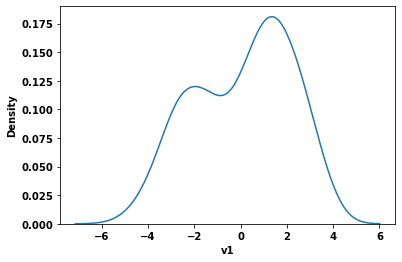

In [924]:
sns.kdeplot(mix_data.v1)

In [1061]:
y = mix_data.v1

coords = {'obs_idx': mix_data.index, 'mus': np.array([0, 1])}
with pm.Model(coords=coords) as model:
    # priors with 2 groups and different means
    mu = pm.Normal('mu', mu=[-1, 1], sigma=10, dims='mus')

    # multivariate beta for the underlying group selecting process
    omega = pm.Dirichlet('omega', a=[1, 1], dims='mus')
    zi = pm.Categorical('z', p=omega, dims='obs_idx')  # choose the group on given prob

    # normal error 
    var = pm.InverseGamma('var', alpha=1/2, beta=1/2)
    sig = pm.Deterministic('sig', pm.math.sqrt(var))
    y_hat = pm.Normal('y_hat', mu=mu[zi], sigma=sig, observed=y, dims='obs_idx')
    
    res = pm.sample(10000, tune=1500, chains=3, return_inferencedata=True)

Multiprocess sampling (3 chains in 4 jobs)
CompoundStep
>NUTS: [var, omega, mu]
>BinaryGibbsMetropolis: [z]


Sampling 3 chains for 1_500 tune and 10_000 draw iterations (4_500 + 30_000 draws total) took 145 seconds.
C:\Users\ztang\miniconda3\envs\pm3env\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [1092]:
az.summary(res, var_names=['mu', 'omega', 'sig'], filter_vars='like')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],-2.125,0.168,-2.453,-1.820,0.001,0.001,13853.0,17132.0,1.0
mu[1],1.489,0.126,1.254,1.725,0.001,0.001,16010.0,18066.0,1.0
omega[0],0.387,0.041,0.309,0.462,0.000,0.000,16935.0,20375.0,1.0
omega[1],0.613,0.041,0.538,0.691,0.000,0.000,16935.0,20375.0,1.0
sig,1.135,0.074,1.001,1.275,0.001,0.000,14245.0,16385.0,1.0


In [1094]:
az.summary(res.isel(obs_idx=[0,30,48,5]), var_names=('z',), filter_vars='like')

C:\Users\ztang\miniconda3\envs\pm3env\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z[0],0.010,0.099,0.0,0.0,0.001,0.000,20101.0,20101.0,1.0
z[30],0.577,0.494,0.0,1.0,0.002,0.002,50110.0,30000.0,1.0
z[48],0.802,0.399,0.0,1.0,0.002,0.002,29556.0,29556.0,1.0
z[5],1.000,0.000,1.0,1.0,0.000,0.000,30000.0,30000.0,NaN


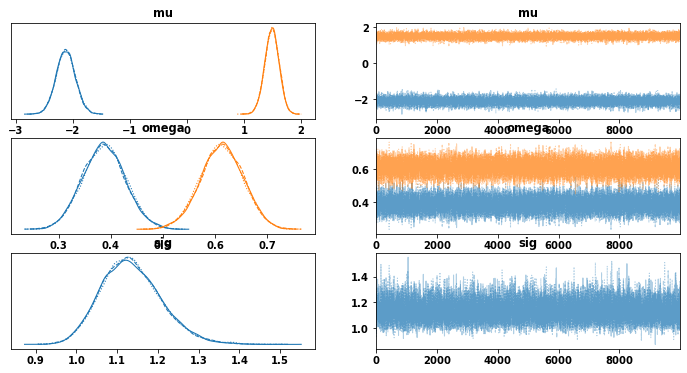

In [1089]:
_ = az.plot_trace(res, var_names=['mu','omega','sig'], compact=True)

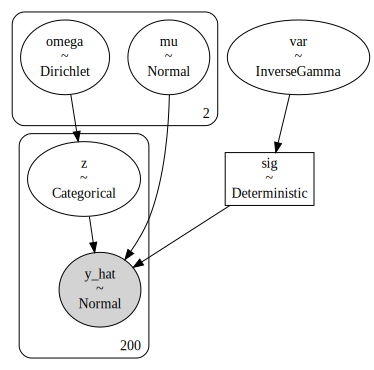

In [1070]:
pm.model_to_graphviz(model)